# Notebook to compare modelled (MERRA-2, SNOWPACK, RACMO2, and MAR) vs observed SMB from IceBridge snow accumulation radar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import xarray as xr
from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from calendar import monthrange

## Load observed SMB from Dattler et. al., 2019

In [2]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

# Transform obs lat/lon into epsg 3031

In [3]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

## Load SNOWPACK SMB

In [4]:
# SNOWPACK SMB
nc_path = "../output/grids/a3d_grids_1980.nc"
# nc_path = "../../nc_storage/550.nc"
ds = xr.open_dataset(nc_path)

# Trim grids
ds = ds.isel(easting=slice(15, -15))
ds = ds.isel(northing=slice(15, -15))

# # SNOWPACK topography 
# dem = np.flipud(np.loadtxt("../input/surface-grids/dem.asc", skiprows=6))
# dem = xr.DataArray(dem, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])

## Determine SNOWPACK domain corners

In [5]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

## Plot observed SMB (blue circles) and model domain (red rectangle)

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


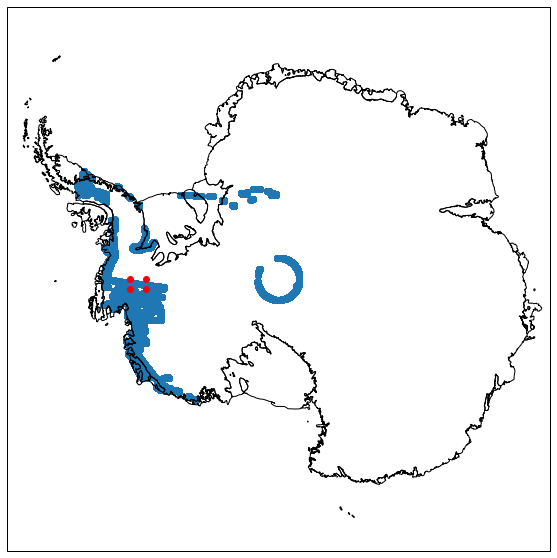

In [6]:
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot obs locations
plt.scatter(obs_X, obs_Y)

# Plot model domain
plt.scatter(domain_left, domain_bottom, c='r')
plt.scatter(domain_left, domain_top, c='r')
plt.scatter(domain_right, domain_bottom, c='r')
plt.scatter(domain_right, domain_top, c='r')

## Determine indices of observations which are in SNOWPACK model domain

In [7]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

## Retrieve observed SMB 

In [8]:
# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

# Relative observations
# obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, relative_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

## Retrieve SNOWPACK SMB

In [9]:
# Retrieve SNOWPACK at observations
SNOWPACK_SMB = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
SNOWPACK_SMB = SNOWPACK_SMB.sel(northing=obs_Y, easting=obs_X, method='nearest')
SNOWPACK_SMB = SNOWPACK_SMB.values.diagonal()
SNOWPACK_SMB = SNOWPACK_SMB * 1000

# # Retrieve elevation at observations
# dem_obs = dem.sel(northing=obs_Y, easting=obs_X, method='nearest')
# dem_obs = dem_obs.values.diagonal()

# Retrieve RACMO2 SMB

In [10]:
import xarray as xr
import pyproj
from pyproj import Proj, transform
from fiona.crs import from_epsg

# Define source epsg and target projection. The later is obtained from ncdump. 
src_epsg = 3031 # Antarctic Stereo
tgt_proj = "-m 57.295779506 +proj=ob_tran +o_proj=latlon +o_lat_p=-167.0 +lon_0=53.0"

# Convert array of lat/lon in source epsg to the rotated grid
rlon_obs, rlat_obs = transform(Proj(from_epsg(src_epsg)), Proj(tgt_proj), obs_X, obs_Y)

# Now retrieve RACMO2 data at grid cells closest to lat/lon array
# R2 = xr.open_dataset("smb_avg.nc")
R2 = xr.open_dataset("year_cum_smb_ASE055_1979-2015.nc")
R2_SMB = R2['smb'].mean(dim='time')

lat_indices = np.zeros(len(rlat_obs)); lat_indices[:] = np.nan
lon_indices = np.zeros(len(rlat_obs)); lon_indices[:] = np.nan
R2_obs = np.zeros(len(rlat_obs)); R2_obs[:] = np.nan

for j in range(0, len(rlat_obs)):
    lat_diff = np.abs(R2['rlat'] - rlat_obs[j])
    lat_indices[j] = np.argmin(lat_diff)
    lon_diff = np.abs(R2['rlon'] - rlon_obs[j])
    lon_indices[j] = np.argmin(lon_diff)
    R2_obs[j] = R2_SMB[0,int(lat_indices[j]), int(lon_indices[j])]

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # This is added back by InteractiveShellApp.init_path()


## Retrieve MERRA-2 SMB

In [11]:
# Calculate seconds in each month from 1980 - 2020
seconds = np.zeros(492); seconds[:] = np.nan
count = -1
for year in range(1980, 2020 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60

# Path
data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Precipitation
sn = xr.open_mfdataset(data_path + "PRECSN_monthly_*.nc", concat_dim="time")
ls = xr.open_mfdataset(data_path + "PRECLS_monthly_*.nc", concat_dim="time")
cu = xr.open_mfdataset(data_path + "PRECCU_monthly_*.nc", concat_dim="time")

# Evaporation 
evap = xr.open_mfdataset(data_path + "EVAP_monthly_*.nc", concat_dim="time")

# SMB
M2_smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
M2_smb = M2_smb.mean(dim='time').mean(dim='month') * seconds.mean() * 12

# Now get MERRA-2 at the observaions locations
M2_obs = M2_smb.sel(lat=obs_lat, lon=obs_lon, method='nearest')
M2_obs = M2_obs.values.diagonal()

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/projects/erke2265/miniconda/

## Retrieve MAR SMB

In [12]:
MAR_path = "/pl/active/nasa_smb/MAR/MARv3.6.4-Antarctica/MERRA2/"
MAR_smb = xr.open_dataset(MAR_path + "MAR-MERRA2_smb_1980-2015_annual.nc4")
MAR_smb = MAR_smb['smb'].mean(dim='time')
MAR_obs = MAR_smb[0,:,:].sel(x=obs_X/1000, y=obs_Y/1000, method='nearest')
MAR_obs = MAR_obs.values.diagonal()

# Get other A3D simulations

In [13]:
# def get_a3d(path, x_trim, y_trim, obs_X, obs_Y):
#     # Open with xarray
#     ds = xr.open_dataset(path)
    
#     # Trim grids
#     ds = ds.isel(easting=slice(x_trim, -x_trim))
#     ds = ds.isel(northing=slice(y_trim, -y_trim))
    
#     # Get SMB
#     SNOWPACK_SMB = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
#     SNOWPACK_SMB = SNOWPACK_SMB.sel(northing=obs_Y, easting=obs_X, method='nearest')
#     SNOWPACK_SMB = SNOWPACK_SMB.values.diagonal()
#     SNOWPACK_SMB = SNOWPACK_SMB * 1000
    
#     # Return SMB
#     return SNOWPACK_SMB

# A3D_base = get_a3d("../../base.nc", 5, 5, obs_X, obs_Y)
# A3D_RL = get_a3d("../../RL.nc", 5, 5, obs_X, obs_Y)
# A3D_FL = get_a3d("../../FL.nc", 5, 5, obs_X, obs_Y)
# A3D_AV = get_a3d("../../AV.nc", 5, 5, obs_X, obs_Y)
# A3D_RL_FL = get_a3d("../../RL_FL.nc", 5, 5, obs_X, obs_Y)

## Horizontal ransect of SNOWPACK vs obserced SMB

Mean Observations
    438.82531396771526

Mean Alpine-3D
    438.82531396771526
    Alpine-3D Factor = 3.0758831939492306

Mean MERRA-2
    434.9278564453125
    MERRA-2 Factor = 1

Mean RACMO2
    404.22104430667065
    RACMO2 Factor = 1

Mean MAR
    486.89874267578125
    MAR Factor = 1


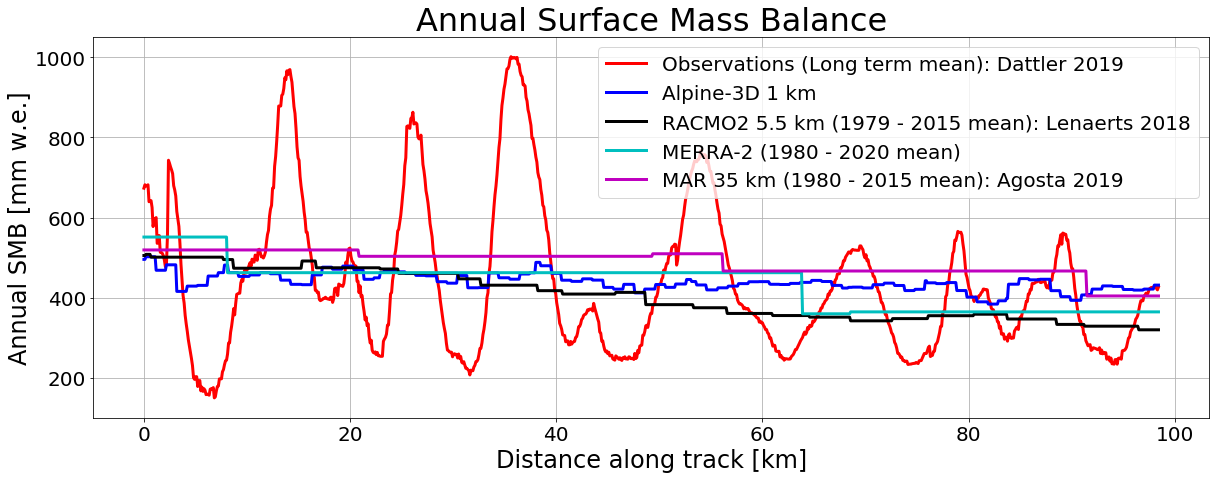

In [14]:
# Indices to plot
ind0 = 1000
indf = 2000
indices = np.arange(ind0, indf)

# Gradient of topography 
# topo_gradient = np.gradient(dem_obs[indices])

# Calculate SNOWPACK multiplicative factor
# By how many timesteps have run
# hy = 24*365 # Hours in a year
# snowpack_factor = hy / len(ds['time'])

# Have the same mean as observations
snowpack_factor = 1000 * obs_accumulation[indices].mean() / SNOWPACK_SMB[indices].mean()
# M2_factor = 1000 * obs_accumulation[indices].mean() / M2_obs[indices].mean()
# R2_factor = 1000 * obs_accumulation[indices].mean() / R2_obs[indices].mean()
# MAR_factor = 1000 * obs_accumulation[indices].mean() / MAR_obs[indices].mean()
# gradient_factor = 1000 * obs_accumulation[indices].mean() / topo_gradient.mean()

# # Constant factor
# snowpack_factor = 1
M2_factor = 1
R2_factor = 1
MAR_factor = 1
gradient_factor = 1

# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

# Plot A3D, and other models
fig, ax1 = plt.subplots(figsize=(20,7))
plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations (Long term mean): Dattler 2019', linewidth=3)
plt.plot(dat, snowpack_factor*SNOWPACK_SMB[indices], 'b', label='Alpine-3D 1 km', linewidth=3)
plt.plot(dat, R2_factor * R2_obs[indices], 'k', label='RACMO2 5.5 km (1979 - 2015 mean): Lenaerts 2018', linewidth=3)
plt.plot(dat, M2_factor * M2_obs[indices], 'c', label='MERRA-2 (1980 - 2020 mean)', linewidth=3)
plt.plot(dat, MAR_factor * MAR_obs[indices], 'm', label='MAR 35 km (1980 - 2015 mean): Agosta 2019', linewidth=3)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.ylabel("Annual SMB [mm w.e.]", fontsize=24)
plt.xlabel("Distance along track [km]", fontsize=24)
plt.title("Annual Surface Mass Balance", fontsize=32)
plt.ylim([100, 1050])
plt.savefig('SMB_Transect.pdf', format='pdf', dpi=100)

# # Plot other versions of A3D
# fig, ax1 = plt.subplots(figsize=(20,7))
# plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations', linewidth=3)
# plt.plot(dat, snowpack_factor*A3D_base[indices], 'b', label='A3D Base', linewidth=3)
# plt.plot(dat, snowpack_factor*A3D_RL[indices], 'k', label='A3D RL = 0.2mm', linewidth=3)
# # plt.plot(dat, snowpack_factor*A3D_FL[indices], 'c', label='A3D FL = 100m', linewidth=3)
# plt.plot(dat, snowpack_factor*A3D_RL_FL[indices], 'm', label='A3D RL FL', linewidth=3)
# # plt.plot(dat, snowpack_factor*A3D_AV[indices], 'm', label='A3D AV = 1/10', linewidth=3)
# plt.legend(fontsize=14)
# plt.grid()
# plt.ylabel("Annual SMB [mm.w.e.]", fontsize=16)
# plt.xlabel("Distance along track [km]", fontsize=16)
# plt.title("1980 Surface Mass Balance", fontsize=16)
# # plt.ylim([0, 1100])
# plt.savefig('SMB_Transect.pdf', format='pdf', dpi=100)

# # Plot elevation
# plt.figure(figsize=(15,5))
# plt.plot(dat, gradient_factor * topo_gradient, label="Elevation")
# plt.xlabel("Distance along track [km]")
# plt.ylabel("Elevation [m]")

# Print mean along track
print("Mean Observations")
print("    " + str(1000 * obs_accumulation[indices].mean()))
print()

print("Mean Alpine-3D")
print("    " + str(snowpack_factor*SNOWPACK_SMB[indices].mean()))
print("    Alpine-3D Factor = " + str(snowpack_factor))
print()

print("Mean MERRA-2")
print("    " + str(M2_factor*M2_obs[indices].mean()))
print("    MERRA-2 Factor = " + str(M2_factor))
print()

print("Mean RACMO2")
print("    " + str(R2_factor*np.mean(R2_obs[indices])))
print("    RACMO2 Factor = " + str(R2_factor))
print()

print("Mean MAR")
print("    " + str(MAR_factor*np.mean(MAR_obs[indices])))
print("    MAR Factor = " + str(MAR_factor))


## Scatter plot of SNOWPACK and observed SMB

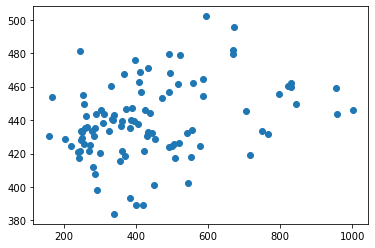

In [15]:
space = 10
plt.scatter(1000*obs_accumulation[indices[::space]], snowpack_factor*SNOWPACK_SMB[indices[::space]])